In [31]:
%matplotlib inline

import paddle
import paddle.fluid as fluid
import numpy as np
import cv2
import math
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [32]:
image_path="../assets/images/face.jpg"
model_path="../assets/models/align150-fp32"

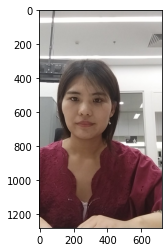

In [33]:
image = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [34]:
def crop(image, pts, shift, scale, rotate, res):
    """checked"""
    if pts.shape[0] == 150 or pts.shape[0] == 72:
        idx1 = 13 # 26 if pts_transform == True else 13
        idx2 = 34 # 24 if pts_transform == True else 34
    elif pts.shape[0] == 4:
        idx1 = 0
        idx2 = 1
    else:
        print("==> Error: abnormal length of pts !")

    # angle between the eyes
    alpha = 0
    if pts[idx2, 0] != -1 and pts[idx2, 1] != -1 and pts[idx1, 0] != -1 and pts[idx1, 1] != -1:
        alpha = math.atan2(pts[idx2, 1] - pts[idx1, 1], pts[idx2, 0] - pts[idx1, 0]) * 180 / math.pi
      
    # pts[pts == -1] = np.inf
    coord_min = np.min(pts, 0)
    # pts[pts == np.inf] = -1
    coord_max = np.max(pts, 0)
    
    # coordinates of center point
    c = np.array([coord_max[0] - (coord_max[0] - coord_min[0]) / 2, 
        coord_max[1] - (coord_max[1] - coord_min[1]) / 2])  # center
    max_wh = max((coord_max[0] - coord_min[0]) / 2, (coord_max[1] - coord_min[1]) / 2)

    # Shift the center point, rot add eyes angle
    c = c + shift * max_wh
    rotate = rotate + alpha

    M = cv2.getRotationMatrix2D((c[0], c[1]), rotate, res[0] / (2 * max_wh * scale))
    M[0, 2] = M[0, 2] - (c[0] - res[0] / 2.0)
    M[1, 2] = M[1, 2] - (c[1] - res[1] / 2.0)

    image_mini = cv2.warpAffine(image, M, res)
    return image_mini, M

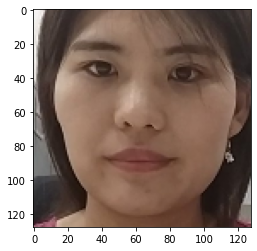

In [35]:
bbox = np.array([141, 468, 409, 468, 409, 736, 141, 736]).reshape([-1, 2])
scale=1.3
res=128,128
n_pt=150
img_mini, M = crop(image, bbox, 0, scale, 0, res)
plt.imshow(cv2.cvtColor(img_mini, cv2.COLOR_BGR2RGB))
plt.show()

In [36]:
def standardize(img, mean, std):
    if img.shape[-1] == 1:
        img = np.repeat(img, axis=2)
    h, w, c = img.shape
    mean = np.array(mean).reshape([3,1])
    std = np.array(std).reshape([3,1])
    img = img.transpose([2,0,1]).reshape([c, -1])
    img = (img - mean) / std
    return img.reshape(c, h, w).transpose([1,2,0])

def prepocess(img, mean=[0.5,0.5,0.5], std=[1,1,1]):
    """
    mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]
    """
    h, w = img.shape[:2]
    img = img / 256.0
    img = standardize(img, mean, std)
    img = img.astype(np.float32).transpose([2,0,1])
    img = img.reshape([-1, 3, h, w])
    return img

inputs = prepocess(img_mini)
print(inputs.shape)

(1, 3, 128, 128)


In [37]:
place = fluid.CPUPlace()
exe = fluid.Executor(place)
inference_scope = fluid.executor.global_scope()
with fluid.scope_guard(inference_scope):
    [inference_program, feed_target_names, fetch_targets] = fluid.io.load_inference_model(model_path, exe, '__model__', '__params__')
    landmark_out, face_score = exe.run(inference_program, feed={feed_target_names[0]:inputs}, fetch_list=fetch_targets, return_numpy=False)

print(landmark_out)
print(face_score)

  - place: CPUPlace
  - shape: [1, 300]
  - layout: NCHW
  - dtype: float
  - data: [13.6652 36.387 14.3876 52.9065 16.9838 69.4023 20.4148 86.1226 29.5587 103.415 44.8342 117.345 61.2861 121.844 78.9232 119.309 97.2356 108.579 109.88 92.2227 114.905 75.1086 118.422 58.0948 120.735 41.3885 29.3489 35.58 34.7459 32.4851 40.5254 31.8735 46.114 33.7656 50.519 38.9551 45.424 39.4485 39.711 39.5536 33.9448 38.129 40.963 35.324 21.6517 24.4981 29.0967 18.5593 37.7611 18.4072 45.8725 20.2344 53.082 26.2159 44.961 25.2373 37.0967 24.0626 29.1274 23.603 78.9492 40.3704 83.9606 35.7669 89.6929 34.3733 95.4595 35.4899 100.653 39.1325 95.961 41.1642 90.3236 42.1254 84.3644 41.5207 89.5442 37.851 76.4427 26.8221 84.7213 21.5492 93.3936 20.36 102.265 21.3882 109.991 28.4031 101.942 26.4464 93.7029 26.0598 85.2211 26.7674 57.1313 39.8449 54.9031 48.9666 52.5519 58.0459 48.7446 68.3355 55.2586 69.0714 69.8785 69.5165 77.2155 69.3437 73.8132 58.5116 72.5454 49.5133 71.3035 40.5708 62.2986 62.8427 42.77

In [38]:
def affine_backward(pts, M):
    coords = pts.copy()
    # import pdb; pdb.set_trace()
    for k, (px, py) in enumerate(pts):
        x = (M[1, 1] * (px - M[0, 2]) + M[0, 1] * (M[1, 2] - py)) / (M[0, 0] * M[1, 1] - M[1, 0] * M[0, 1])
        y = (M[1, 0] * (px - M[0, 2]) + M[0, 0] * (M[1, 2] - py)) / (M[0, 1] * M[1, 0] - M[1, 1] * M[0, 0])
        coords[k, 0], coords[k, 1] = x, y
    return coords

lmk_pred = np.array(landmark_out).reshape([-1,2])[:150, :]
lmk_pred = affine_backward(lmk_pred, M)
print(lmk_pred.shape)

(150, 2)


In [39]:
def draw_landmark(img, pts, dsize = 1, color = (0, 0, 255), number = False):
    '''Example function with types documented in the docstring.'''
    if len(pts) == 0:
        print("No point found !")
    else:
        for j in range(pts.shape[0]):
            location = (int(pts[j, 0]), int(pts[j, 1]))
            cv2.circle(img, location, dsize, color, -1)
            if number:
                location = (location[0] + 10, location[1] + 5)
                cv2.putText(img, str(j), location, cv2.FONT_HERSHEY_COMPLEX, 0.4, (255,0,0), 2)
    return img

image = draw_landmark(image, lmk_pred[:150, :])
cv2.imwrite("align150-out.jpg", image)

True

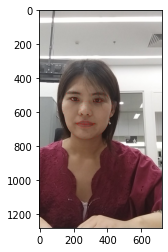

In [40]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()